In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
idx = pd.IndexSlice
pd.set_option("display.max_rows",101)
pd.set_option('expand_frame_repr', False)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# MRChem benchmark calculations

This notebook presents benchmark timings for the MRChem program on a set of molecular calculations using a variable number of CPU cores. The test systems are standard linear alkane chains $C_nH_{2n+2}$, with $n$ ranging from 2 to 350, as well as the Caffeine ($C_{8}H_{10}N_{4}O_{2}$) and Valinomycine ($C_{54}H_{90}N_{6}O_{18}$) molecules. The main purpose of this data is to monitor the development of the code performance between different version, but it will also provide a reference for users to check if the code has been properly installed and runs reasonably on their system. Not all molecular systems will be available in the data, which mirrors the current limitations of the code when it comes to system size and numerical precision. Only a small selection of the data will be presented below, but further details are available by digging into the raw data.

### MRChem version : pre-release

```
Commit   : 0e4c064a24c331b598041235a8a9989c3bfe436f
Date     : Mon Oct 22 11:48:33 2018 +0200
```

### Hardware configuration

```
Cluster  : Fram
Host     : UiT - The Arctic University of Norway
System   : Lenovo NeXtScale nx360
CPU type : Intel E5-2683v4 2.1GHz
Core     : 2 x 16-core Intel Broadwell
Memory   : 64GiB
Network  : Infiniband
```

## MRChem SCF cycle

The presented data will focus on the main workhorse algorithm in computational chemistry: the Self-Consistent Field (SCF) optimization. A single SCF cycle in MRChem contains the following steps:

- Building Fock operator
- Calculating Fock matrix
- Rotatingorbitals (diagonalization or localization)
- Calculating SCF energy
- Applying Helmholtz operator
- Applying iterative subspace acceleration (KAIN)

and each of these may have sub steps that can be extracted from the data below. The calculations are performed using one of the following methods:

- Hartree (to show the performance of the backbone SCF algorithm + Coulomb interaction)
- Hartree-Fock (to show the performance of the exact exchange operator)
- DFT-PBE (to show the performance of the density functional integrator)

## Parallel performance

The following table presents timings (in sec) for the different parts of a single SCF cycle for the $C_{6}H_{14}$
molecule at numerical precision $\epsilon=10^{−5}$, using the PBE density functional. The calculations are using an increasing number of MPI processes and OMP threads per process. The molecule has 50 electrons and 25 doubly occupied molecular orbitals.

In [2]:
prec=5
molecule='alkane_006'
hybrid_series = pd.read_csv("alkane-PBE/scf.csv", index_col=[0,1,2,3]).loc[molecule,prec,:,:]
hybrid_series

Localize  SCF energy  Helmholtz       KAIN  Fock operator  Fock matrix  Total SCF
molecule   prec MPI OMP                                                                                    
alkane_006 5    1   1    127.71900   121.81100  1649.0500  23.635200      174.42200    148.32100  2248.7500
                    2     73.69760    62.76790   840.7890  14.403600       89.26000     81.48430  1166.1500
                    4     48.65540    34.41750   433.0210  10.613600       46.42960     48.52390   625.0700
                    8     33.69560    17.42760   232.8710   7.850790       23.83680     29.38490   348.9580
                    16    27.48050    10.71240   137.3470   6.389210       13.22990     21.08690   219.9350
                    32    24.33770     6.59685    89.1775   5.756600        7.81744     16.77450   153.7070
                2   1     73.50260    64.19620   859.6330  13.109500      154.32600     81.43330  1253.8900
                    2     43.88450    32.96710   438.9600   7.789570       78.56270     44.93850   653.1480
                    4     29.04230    16.72810   225.7310   5.009560       39.62940     26.19830   347.4560
                    8     21.46010     8.65414   119.5560   3.708020       20.73570     16.71950   195.6670
                    16    17.70190     4.83418    70.6391   3.283890       11.58760     11.80620   123.6930
                    32    54.01990    10.98740    89.6883   3.708880       13.62670     17.34960   194.0540
                4   1     57.06140    36.24050   503.7210  10.411600      174.38200     66.74260   855.7340
                    2     32.02810    20.39850   259.5020   4.975070       91.84390     34.57880   449.2870
                    4     25.50290    10.79530   134.3420   4.186670       49.58690     22.33470   250.8600
                    8     21.92440     5.62507    70.3042   3.158080       26.66260     12.61770   144.0080
                    16    21.20580     4.12127    49.1032   2.428110       15.42840      9.24176   104.9180
                    32    21.06460     3.61891    43.2311   1.977590       11.70000      8.83441    93.8578
                8   1     34.77340    22.04870   290.8040   4.503240      166.99800     30.35150   558.0580
                    2     19.45100    10.41770   134.7280   2.898430       84.80440     18.74710   276.3850
                    4     13.02540     5.37582    79.5025   1.951150       43.90390     10.18650   157.8830
                    8     11.20580     3.16964    41.2875   1.156360       22.78360      6.66866    89.8724
                    16    10.70730     1.99949    24.9173   1.034400       15.22530      5.54448    62.5219
                    32    11.85060     2.00717    25.3878   1.359810       11.62990      4.93149    59.7064
                16  1     20.27950    12.76730   171.8800   3.182940      165.14700     19.55640   401.3950
                    2     13.23750     7.82247    85.8466   2.585180       85.58990     11.15510   211.4980
                    4      9.33639     3.92476    46.3002   1.473410       44.88580      6.69320   116.7620
                    8      7.95470     2.30348    24.0706   1.369250       23.98750      5.02975    67.9264
                    16     6.68085     1.46144    15.3698   0.943445       14.88430      3.58032    45.6236
                    32     6.96181     1.44496    15.9684   0.965964       13.15930      3.82150    45.1024

## OpenMP scaling

The following table presents timings (in sec) on a single compute node for the different parts of a single SCF cycle for the $C_{6}H_{14}$ molecule at numerical precision $\epsilon=10^{-5}$, using the PBE density functional. The molecule has 50 electrons and 25 doubly occupied molecular orbitals.

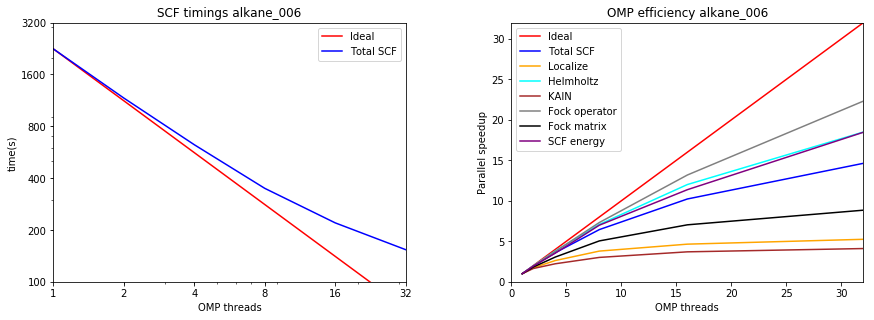

,Localize,SCF energy,Helmholtz,KAIN,Fock operator,Fock matrix,Total SCF
OMP,,,,,,,
1,127.7190,121.81100,1649.0500,23.63520,174.42200,148.3210,2248.750
2,73.6976,62.76790,840.7890,14.40360,89.26000,81.4843,1166.150
4,48.6554,34.41750,433.0210,10.61360,46.42960,48.5239,625.070
8,33.6956,17.42760,232.8710,7.85079,23.83680,29.3849,348.958
16,27.4805,10.71240,137.3470,6.38921,13.22990,21.0869,219.935
32,24.3377,6.59685,89.1775,5.75660,7.81744,16.7745,153.707


In [3]:
mpi=1
prec=5
molecule='alkane_006'
omp_series = pd.read_csv("alkane-PBE/scf.csv", index_col=[0,1,2,3]).loc[molecule,prec,mpi]

plt.subplot(121)
plt.title('SCF timings alkane_006')
plt.plot(omp_series.index, omp_series['Total SCF'][1]/omp_series.index, 'r', label='Ideal')
plt.plot(omp_series['Total SCF'], 'b', label='Total SCF')
plt.legend(loc='upper right')
plt.axis([1, 32, 100, 3200])
plt.yscale('log')
plt.xscale('log')
plt.yticks([100, 200, 400, 800, 1600, 3200], [100, 200, 400, 800, 1600, 3200])
plt.xticks([1, 2, 4, 8, 16, 32], [1, 2, 4, 8, 16, 32])
plt.ylabel('time(s)')
plt.xlabel('OMP threads')

plt.subplot(122)
plt.title('OMP efficiency alkane_006')
plt.plot(omp_series.index, omp_series.index, 'r', label='Ideal')
plt.plot(omp_series['Total SCF'][1]/omp_series['Total SCF'], 'b', label='Total SCF')
plt.plot(omp_series['Localize'][1]/omp_series['Localize'], c='orange', label='Localize')
plt.plot(omp_series['Helmholtz'][1]/omp_series['Helmholtz'], c='cyan', label='Helmholtz')
plt.plot(omp_series['KAIN'][1]/omp_series['KAIN'], c='brown', label='KAIN')
plt.plot(omp_series['Fock operator'][1]/omp_series['Fock operator'], c='gray', label='Fock operator')
plt.plot(omp_series['Fock matrix'][1]/omp_series['Fock matrix'], c='black', label='Fock matrix')
plt.plot(omp_series['SCF energy'][1]/omp_series['SCF energy'], c='purple', label='SCF energy')
plt.legend(loc='upper left')
plt.axis([0, 32, 0, 32])
plt.ylabel('Parallel speedup')
plt.xlabel('OMP threads')

plt.subplots_adjust(top=1.0, bottom=0.1, right=2, wspace=.30)
plt.show()
omp_series

## MPI scaling

The following table presents timings (in sec) for the different parts of a single SCF cycle for the $C_{6}H_{14}$
molecule at numerical precision $\epsilon=10^{−5}$, using the PBE density functional. The calculations are using an increasing number of MPI processes with fixed a single OMP threads per process. The molecule has 50 electrons and 25 doubly occupied molecular orbitals.

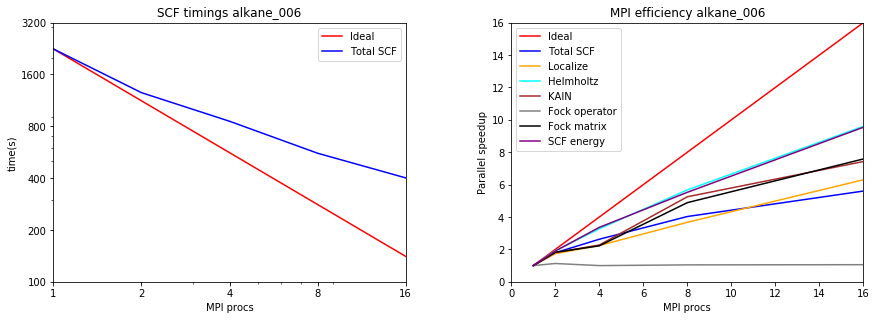

,Localize,SCF energy,Helmholtz,KAIN,Fock operator,Fock matrix,Total SCF
MPI,,,,,,,
1,127.7190,121.8110,1649.050,23.63520,174.422,148.3210,2248.750
2,73.5026,64.1962,859.633,13.10950,154.326,81.4333,1253.890
4,57.0614,36.2405,503.721,10.41160,174.382,66.7426,855.734
8,34.7734,22.0487,290.804,4.50324,166.998,30.3515,558.058
16,20.2795,12.7673,171.880,3.18294,165.147,19.5564,401.395


In [4]:
omp=1
prec=5
molecule='alkane_006'
mpi_series = pd.read_csv("alkane-PBE/scf.csv", index_col=[0,1,3,2]).loc[molecule,prec,omp]

plt.subplot(121)
plt.title('SCF timings alkane_006')
plt.plot(mpi_series.index, mpi_series['Total SCF'][1]/mpi_series.index, 'r', label='Ideal')
plt.plot(mpi_series['Total SCF'], 'b', label='Total SCF')
plt.legend(loc='upper right')
plt.axis([1, 16, 100, 3200])
plt.yscale('log')
plt.xscale('log')
plt.yticks([100, 200, 400, 800, 1600, 3200], [100, 200, 400, 800, 1600, 3200])
plt.xticks([1, 2, 4, 8, 16], [1, 2, 4, 8, 16])
plt.ylabel('time(s)')
plt.xlabel('MPI procs')

plt.subplot(122)
plt.title('MPI efficiency alkane_006')
plt.plot(mpi_series.index, mpi_series.index, c='red', label='Ideal')
plt.plot(mpi_series['Total SCF'][1]/mpi_series['Total SCF'], c='blue', label='Total SCF')
plt.plot(mpi_series['Localize'][1]/mpi_series['Localize'], c='orange', label='Localize')
plt.plot(mpi_series['Helmholtz'][1]/mpi_series['Helmholtz'], c='cyan', label='Helmholtz')
plt.plot(mpi_series['KAIN'][1]/mpi_series['KAIN'], c='brown', label='KAIN')
plt.plot(mpi_series['Fock operator'][1]/mpi_series['Fock operator'], c='gray', label='Fock operator')
plt.plot(mpi_series['Fock matrix'][1]/mpi_series['Fock matrix'], c='black', label='Fock matrix')
plt.plot(mpi_series['SCF energy'][1]/mpi_series['SCF energy'], c='purple', label='SCF energy')
plt.legend(loc='upper left')
plt.axis([0, 16, 0, 16])
plt.ylabel('Parallel speedup')
plt.xlabel('MPI procs')

plt.subplots_adjust(top=1.0, bottom=0.1, right=2, wspace=.30)
plt.show()
mpi_series

## Hybrid MPI/OpenMP scaling

The following table presents timings (in sec) for the different parts of a single SCF cycle for the $C_{6}H_{14}$
molecule at numerical precision $\epsilon=10^{−5}$, using the PBE density functional. The calculations are using an increasing number of MPI processes with fixed 8 OMP threads per process. The molecule has 50 electrons and 25 doubly occupied molecular orbitals.

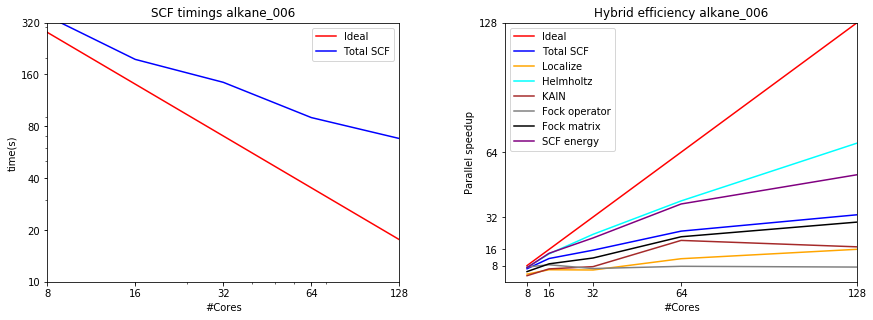

,Localize,SCF energy,Helmholtz,KAIN,Fock operator,Fock matrix,Total SCF
MPI,,,,,,,
1,33.6956,17.42760,232.8710,7.85079,23.8368,29.38490,348.9580
2,21.4601,8.65414,119.5560,3.70802,20.7357,16.71950,195.6670
4,21.9244,5.62507,70.3042,3.15808,26.6626,12.61770,144.0080
8,11.2058,3.16964,41.2875,1.15636,22.7836,6.66866,89.8724
16,7.9547,2.30348,24.0706,1.36925,23.9875,5.02975,67.9264


In [5]:
omp=8
prec=5
molecule='alkane_006'
hybrid_series = pd.read_csv("alkane-PBE/scf.csv", index_col=[0,1,3,2]).loc[molecule,prec,omp]

plt.subplot(121)
plt.title('SCF timings alkane_006')
plt.plot(hybrid_series.index, omp_series['Total SCF'][1]/(omp*hybrid_series.index), 'r', label='Ideal')
plt.plot(hybrid_series['Total SCF'], 'b', label='Total SCF')
plt.legend(loc='upper right')
plt.axis([1, 16, 10, 320])
plt.yscale('log')
plt.xscale('log')
plt.yticks([10, 20, 40, 80, 160, 320], [10, 20, 40, 80, 160, 320])
plt.xticks([1, 2, 4, 8, 16], [omp*1, omp*2, omp*4, omp*8, omp*16])
plt.ylabel('time(s)')
plt.xlabel('#Cores')

plt.subplot(122)
plt.title('Hybrid efficiency alkane_006')
plt.plot(hybrid_series.index, hybrid_series.index, c='red', label='Ideal')
plt.plot(omp_series['Total SCF'][1]/(omp*hybrid_series['Total SCF']), c='blue', label='Total SCF')
plt.plot(omp_series['Localize'][1]/(omp*hybrid_series['Localize']), c='orange', label='Localize')
plt.plot(omp_series['Helmholtz'][1]/(omp*hybrid_series['Helmholtz']), c='cyan', label='Helmholtz')
plt.plot(omp_series['KAIN'][1]/(omp*hybrid_series['KAIN']), c='brown', label='KAIN')
plt.plot(omp_series['Fock operator'][1]/(omp*hybrid_series['Fock operator']), c='gray', label='Fock operator')
plt.plot(omp_series['Fock matrix'][1]/(omp*hybrid_series['Fock matrix']), c='black', label='Fock matrix')
plt.plot(omp_series['SCF energy'][1]/(omp*hybrid_series['SCF energy']), c='purple', label='SCF energy')
plt.legend(loc='upper left')
plt.axis([0, 16, 0, 16])
plt.yticks([1, 2, 4, 8, 16], [omp*1, omp*2, omp*4, omp*8, omp*16])
plt.xticks([1, 2, 4, 8, 16], [omp*1, omp*2, omp*4, omp*8, omp*16])
plt.ylabel('Parallel speedup')
plt.xlabel('#Cores')

plt.subplots_adjust(top=1.0, bottom=0.1, right=2, wspace=.30)
plt.show()
hybrid_series

## System scaling


In [8]:
omp=16
mpi=8
prec=5
mol_series = pd.read_csv("alkane-PBE/scf.csv", index_col=[1,2,3,0]).loc[prec,mpi,omp]
mol_series

,Localize,SCF energy,Helmholtz,KAIN,Fock operator,Fock matrix,Total SCF
molecule,,,,,,,
alkane_002,1.87508,0.618292,9.74914,0.401981,6.55947,1.37946,21.2709
alkane_004,4.40618,1.125760,16.90030,0.709474,10.17400,3.10518,38.6980
alkane_006,10.70730,1.999490,24.91730,1.034400,15.22530,5.54448,62.5219
alkane_008,19.96170,3.214560,35.93050,1.649870,19.87190,9.17560,94.7851
alkane_010,37.22040,3.754420,45.55800,2.265460,25.24670,11.30580,134.1100
alkane_020,105.38300,9.021310,140.27500,3.975040,80.36330,28.01370,394.6210


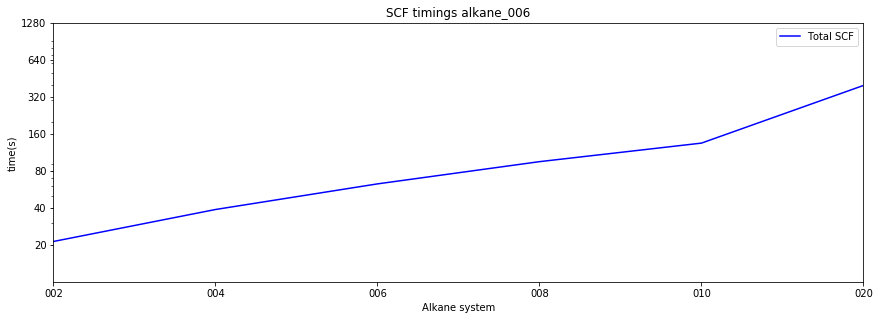

In [9]:
plt.title('SCF timings alkane_006')
plt.plot(mol_series['Total SCF'], 'b', label='Total SCF')
plt.legend(loc='upper right')
plt.axis([1, 5, 10, 1000])
plt.yscale('log')
plt.yticks([20, 40, 80, 160, 320, 640, 1280], [20, 40, 80, 160, 320, 640, 1280])
plt.xticks([0, 1, 2, 3, 4, 5], ['002', '004', '006', '008', '010', '020'])
plt.ylabel('time(s)')
plt.xlabel('Alkane system')

plt.subplots_adjust(top=1.0, bottom=0.1, right=2, wspace=.30)
plt.show()
